In [35]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
from LRBv21 import LRBv21
from AnalyticCoolingCurves import *
from unpackConfigurationsMK import *
from refineGrid import refineGrid
from Morph import Profile, Morph

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *
import general.plotstyle

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read balance file

In [36]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 2000)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
# file_write(eqb, "equilibrium.pkl")

# Setup and run DLS

In [37]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Morph1: Move inner target down to outer target level

In [5]:
%matplotlib inline
plt.close("all")

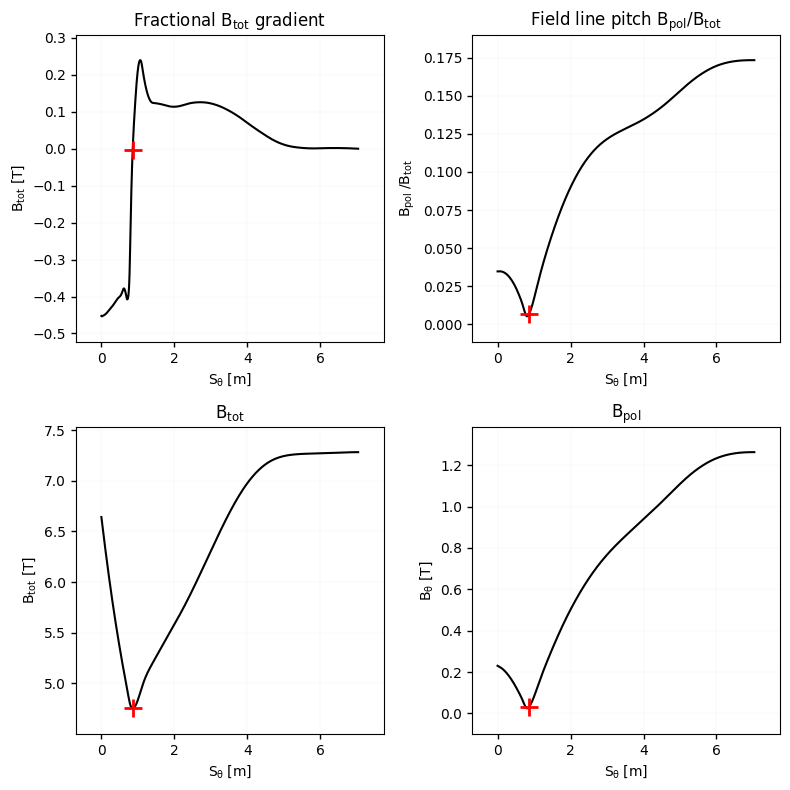

In [8]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])

base.plot_topology()

In [6]:
%matplotlib inline

(-9.0, -5.8)

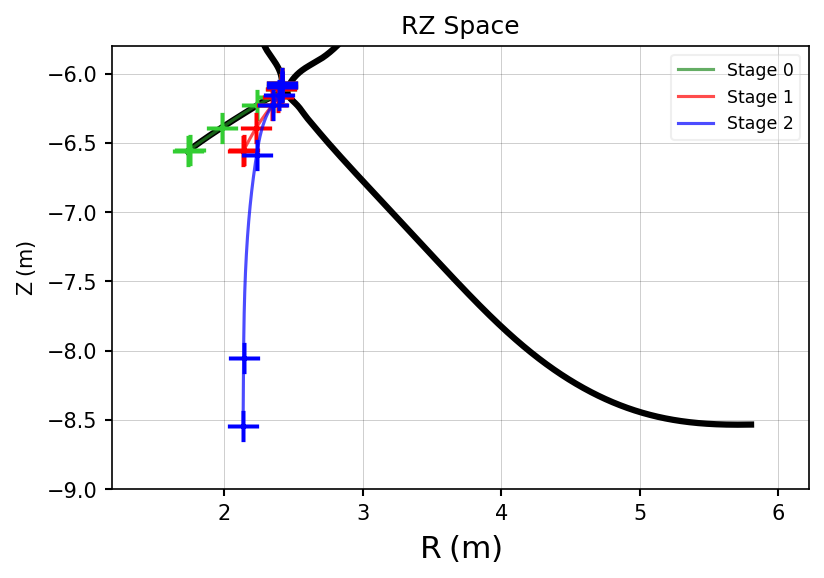

In [38]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])

base_offsets = [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.85},
    {"pos" : 0.7},
    {"pos" : 0.35},
    {"pos" : 0.02},
    {"pos" : 0.0},
    ]

offsets_stage1 = [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.85,  "offsety": 0, "offsetx": 0.04},
    {"pos" : 0.7,   "offsety": 0, "offsetx": 0.11},
    {"pos" : 0.35,  "offsety": 0, "offsetx": 0.25},
    {"pos" : 0.02,  "offsety": 0, "offsetx": 0.392},
    {"pos" : 0.0,   "offsety": 0, "offsetx": 0.4},
    ]

offsets_stage2 = [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.85,  "offsety": 0},
    {"pos" : 0.7,   "offsety": 0},
    {"pos" : 0.35,  "offsety": -0.2},
    {"pos" : 0.02,  "offsety": -1.5, "offsetx": -0.002},
    {"pos" : 0.0,   "offsety": -1.98},
    ]


# Make stage 0 by copying the base profile
stage0 = base.copy()
stage0.offset_control_points(base_offsets)
stage0.name = "Stage 0"

# Make stage 1 by offsetting stage 0
stage1 = base.copy()
stage1.offset_control_points(offsets_stage1)
stage1.recalculate_topology()
stage1.name = "Stage 1"

# Make stage 2 by offseting stage 1
stage2 = stage1.copy()
stage2.offset_control_points(offsets_stage2)
stage2.recalculate_topology()
stage2.name = "Stage 2"



plt.close("all")
fig, ax = plt.subplots(dpi = 150)
ax.plot(base.R, base.Z, lw = 3, c = "k")
stage0.plot_control_points(ax = ax)
stage1.plot_control_points(ax = ax, markersettings = {"c" : "r"}, linesettings = {"c" : "r"})
stage2.plot_control_points(ax = ax, markersettings = {"c" : "b"}, linesettings = {"c" : "b"})

d_outer = eqb["SPR45"]["ol"]
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)

ax.legend(fontsize = "small")
ax.set_ylim(-9, -5.8)

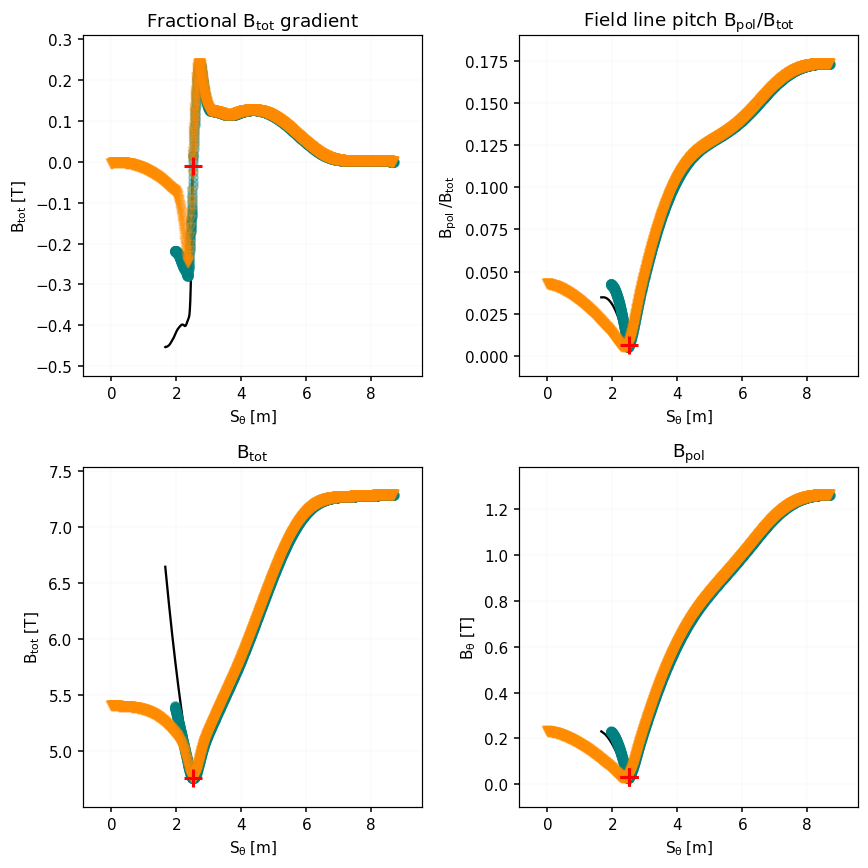

In [39]:
compare_profile_topologies(stage0, [stage1, stage2])

## Morph between any two

In [45]:
%matplotlib widget

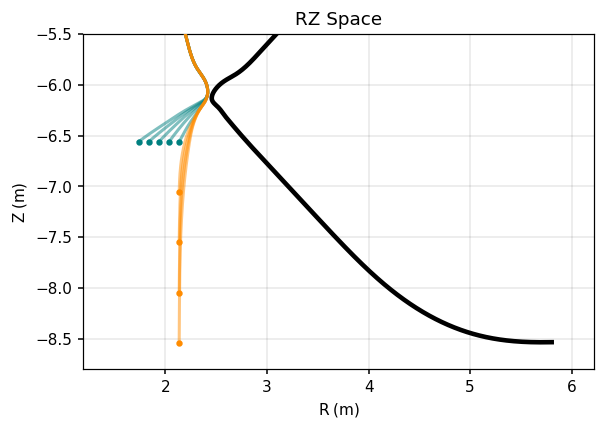

In [40]:
start = stage0.copy()
end = stage1.copy()
new = stage0.copy()
factor = 0

# Make stage 1 by offsetting stage 0
new = base.copy()
new.offset_control_points(offsets_stage1, factor = factor)
new.recalculate_topology()
new.name = "New"

profiles = {}
for i in np.linspace(0,1,5):
    profiles[i] = base.copy()
    profiles[i].offset_control_points(offsets_stage1, factor = i)
    profiles[i].recalculate_topology()
    profiles[i].name = i

for i in np.linspace(1,2,5):
    profiles[i] = stage1.copy()
    profiles[i].offset_control_points(offsets_stage2, factor = i-1)
    profiles[i].recalculate_topology()
    profiles[i].name = i

plt.close("all")
fig, ax = plt.subplots(1, figsize = (6,12))

profs = {}
for i in profiles:
 
    p = profiles[i]
    
    c = "teal" if i <= 1 else "darkorange"
    
    ax.plot(p.R, p.Z, zorder = 100, alpha = 0.5, lw = 2, ls = "-", c = c)
    ax.scatter(p.R[0], p.Z[0], c = c, s = 10)

d_outer = eqb["SPR45"]["ol"]
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)

ax.set_xlabel("$R\ (m)$")
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

In [41]:
cvar = "density"
design = "SPR45"
side = "il"

store = dict()

    
for i in profiles:
    d = profiles[i].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 5) # Solve at these parallel positions
    
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9

    results = LRBv21(
        constants, 
        radios, 
        d, 
        SparRange, 
        verbosity = 0, control_variable = cvar, 
        Ctol = 1e-3, Ttol=1e-3,
        dynamicGrid = True,
        dynamicGridRefinementRatio = 20)
    
    store[i] = copy.deepcopy(results)

Solving...0.00...12.89...25.78...38.68...51.57...Complete in 17.9 seconds
Solving...0.00...11.49...22.97...34.46...45.95...Complete in 19.8 seconds
Solving...0.00...10.21...20.42...30.63...40.83...Complete in 19.3 seconds
Solving...0.00...9.08...18.16...27.24...36.32...Complete in 19.8 seconds
Solving...0.00...8.13...16.27...24.40...32.54...Complete in 17.9 seconds
Solving...0.00...15.13...30.26...45.39...60.52...Complete in 18.7 seconds
Solving...0.00...22.43...44.85...67.28...89.70...Complete in 18.9 seconds
Solving...0.00...29.82...59.64...89.46...119.28...Complete in 18.8 seconds
Solving...0.00...37.27...74.54...111.81...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


149.08...Complete in 19.9 seconds


In [231]:
file_write(store, "2024-01-23 - New inner divertor - 100 points.pkl")

C:\Users\mikek\AppData\Local\Temp\ipykernel_22084\1550407324.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


Text(0.5, 1.0, 'Front position response to upstream density')

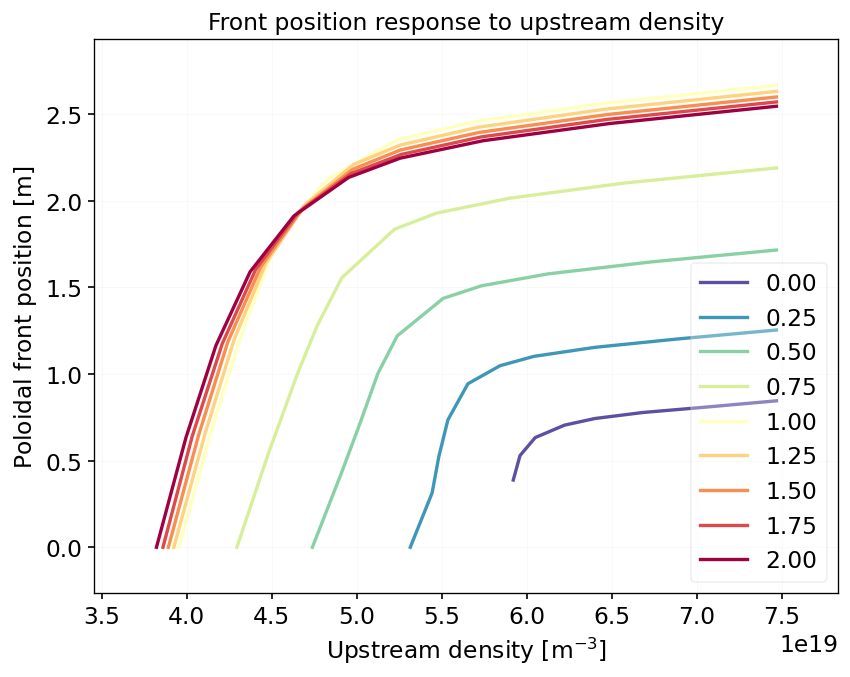

In [23]:
fig, ax = plt.subplots()
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.2f}", color = colors[i], **style)
    
ax.legend()
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()

KeyError: 'Xpoints'

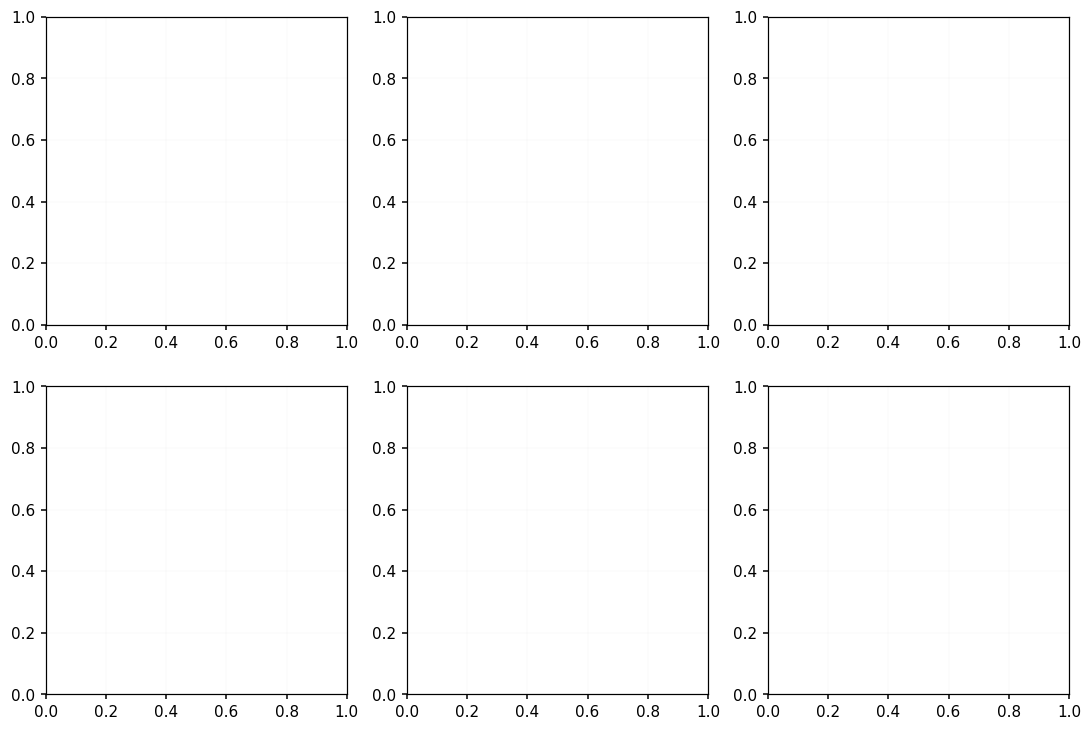

In [34]:
labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]

windows = []

fig, axes = plt.subplots(2,3, dpi = 110, figsize = (12,8))


    

windows = np.array([store[x]["window_ratio"] for x in profiles])

thresholds = np.array([store[x]["threshold"] for x in profiles])
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])
front_dfs = [get_front_widths(profiles[x], store[x], Rcutoff = 0.9) for x in profiles]
BxBt_eff = [df["Btot_eff"].iloc[-1] / df["Btot_eff"].iloc[0] for df in front_dfs]

avgB_ratio_eff = []
for df in front_dfs:
    newS = np.linspace(df["Spar"].iloc[0], df["Spar"].iloc[-1], 100)
    Btot_eff_interp = sp.interpolate.make_interp_spline(df["Spar"], df["Btot_eff"])(newS)
    avgB_ratio_eff.append(df["Btot"].iloc[-1] / np.mean(Btot_eff_interp))

target_sens = np.array([get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in profiles])

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]
    
threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc3 = (BxBt_eff/BxBt_eff[0])**(-1) * (L/L_base)**(-4/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(2/7)

windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc3 = (BxBt_eff/BxBt_eff[0])**(1) * (L/L_base)**(4/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(-2/7)

index = profiles.keys()

# index = np.linspace(0,1,5)+i
axes[0,0].set_title("Connection length")
axes[0,0].plot(index, L/L_base, marker = "o")

axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
axes[0,1].plot(index, BxBt/BxBt_base, marker = "o")

axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
axes[0,2].plot(index, frac_gradB, marker = "o")

axes[1,0].set_title(r"Detachment threshold")
axes[1,0].plot(index, thresholds/threshold_base, marker = "o")

lw = 2
axes[1,0].plot(index, threshcalc, lw = lw, color = "skyblue", ls = ":", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,0].plot(index, threshcalc2, lw = lw, color = "darkorange", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,0].plot(index, threshcalc3, lw = lw, color = "deeppink", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$, $B_{eff}$")
axes[1,0].legend(fontsize = "medium")

axes[1,1].set_title(r"Detachment window")
axes[1,1].plot(index, windows/window_base, marker = "o")
axes[1,1].plot(index, windowcalc, lw = lw, color = "skyblue", ls = ":", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,1].plot(index, windowcalc2, lw = lw, color = "darkorange", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,1].plot(index, windowcalc3, lw = lw, color = "deeppink", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$, $B_{eff}$")
axes[1,1].legend(fontsize = "medium")

axes[1,2].set_title(r"Sensitivity @ target")
axes[1,2].plot(index, target_sens, marker = "o")

for ax in axes.flatten():
    ax.set_xlabel("Profile change")

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")
    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()